<a href="https://colab.research.google.com/github/sunghyouk/study_room/blob/master/py_beyesian/ch2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter2. PyMC 더 알아보기

## 2.1 서론

In [1]:
import pymc3 as pm
import matplotlib

with pm.Model() as model:
    parameter = pm.Exponential("poisson_param", 1.0)
    data_generator = pm.Poisson("data_generator", parameter)

In [2]:
with model:
    data_plus_one = data_generator + 1

In [3]:
parameter.tag.test_value

array(0.69314718)

In [4]:
with pm.Model() as model:
    theta = pm.Exponential("theta", 2.0)
    data_generator = pm.Poisson("data_generator", theta)

In [5]:
with pm.Model() as ab_testing:
    p_A = pm.Uniform("P(A)", 0, 1)
    p_B = pm.Uniform("P(B)", 0, 1)

### 2.1.2 PyMC 변수

In [6]:
print("parameter.tag.test_value =", parameter.tag.test_value)
print("data_generator.tag.test_value =", data_generator.tag.test_value)
print("data_plus_one.tag.test_value =", data_plus_one.tag.test_value)

parameter.tag.test_value = 0.6931471824645996
data_generator.tag.test_value = 0
data_plus_one.tag.test_value = 1


In [7]:
with pm.Model() as model:
    parameter = pm.Exponential("poisson_param", 1.0, testval=0.5)

print("\nparameter.tag.test_value =", parameter.tag.test_value)


parameter.tag.test_value = 0.5


* stochastic 변수 초기화
* deterministic 변수

In [8]:
with pm.Model() as model:
    lambda_1 = pm.Exponential("lambda_1", 1.0)
    lambda_2 = pm.Exponential("lambda_2", 1.0)
    tau = pm.DiscreteUniform("tau", lower=0, upper=10)

new_deterministic_variable = lambda_1 + lambda_2

In [9]:
import numpy as np

n_data_points = 5  # in CH1 we had ~70 data points
idx = np.arange(n_data_points)
with model:
    lambda_ = pm.math.switch(tau >= idx, lambda_1, lambda_2)

#### Theano

In [10]:
import theano.tensor as tt

with pm.Model() as theano_test:
    p1 = pm.Uniform("p", 0, 1)
    p2 = 1 - p1
    p = tt.stack([p1, p2])
    
    assignment = pm.Categorical("assignment", p)

### 2.1.3 모델에 관측 포함하기

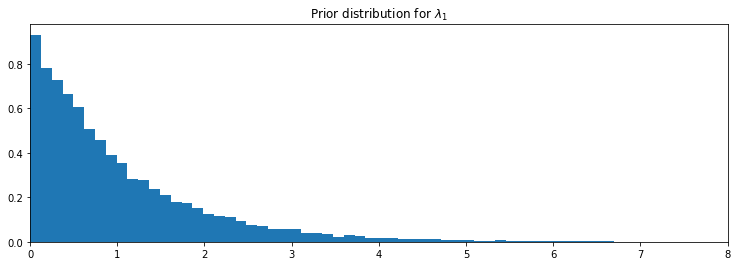

In [11]:
%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import scipy.stats as stats
figsize(12.5, 4)


samples = lambda_1.random(size=20000)
plt.hist(samples, bins=70, density=True, histtype="stepfilled")
plt.title("Prior distribution for $\lambda_1$")
plt.xlim(0, 8);

In [12]:
data = np.array([10, 5])
with model:
    fixed_variable = pm.Poisson("fxd", 1, observed=data)
print("value: ", fixed_variable.tag.test_value)

value:  [10  5]


In [13]:
# We're using some fake data here
data = np.array([10, 25, 15, 20, 35])
with model:
    obs = pm.Poisson("obs", lambda_, observed=data)
print(obs.tag.test_value)

[10 25 15 20 35]


## 2.2 모델링 방법

### 2.2.6 이항분포

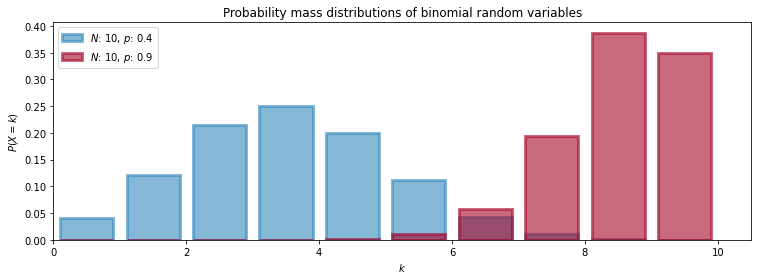

In [14]:
figsize(12.5, 4)

import scipy.stats as stats
binomial = stats.binom

parameters = [(10, .4), (10, .9)]
colors = ["#348ABD", "#A60628"]

for i in range(2):
    N, p = parameters[i]
    _x = np.arange(N + 1)
    plt.bar(_x - 0.5, binomial.pmf(_x, N, p), color=colors[i],
            edgecolor=colors[i],
            alpha=0.6,
            label="$N$: %d, $p$: %.1f" % (N, p),
            linewidth=3)

plt.legend(loc="upper left")
plt.xlim(0, 10.5)
plt.xlabel("$k$")
plt.ylabel("$P(X = k)$")
plt.title("Probability mass distributions of binomial random variables");

### 2.2.7 예제: 학생들의 부정행위

In [15]:
import pymc3 as pm

N = 100
with pm.Model() as model:
    p = pm.Uniform("freq_cheating", 0, 1)

In [16]:
with model:
    true_answers = pm.Bernoulli("truths", p, shape = N, testval = np.random.binomial(1, 0.5, N))

In [17]:
with model:
    first_coin_flips = pm.Bernoulli("first_flips", 0.5, shape=N, testval=np.random.binomial(1, 0.5, N))

In [18]:
with model:
    second_coin_flips = pm.Bernoulli("second_flips", 0.5, shape=N, testval=np.random.binomial(1, 0.5, N))

In [19]:
import theano.tensor as tt
with model:
    val = first_coin_flips*true_answers + (1 - first_coin_flips)*second_coin_flips
    observed_proportion = pm.Deterministic("observed_proportion", tt.sum(val)/float(N))

In [20]:
observed_proportion.tag.test_value

array(0.52999997)

In [21]:
X = 35

with model:
    observations = pm.Binomial("obs", N, observed_proportion, observed=X)

In [22]:
# To be explained in Chapter 3!
with model:
    step = pm.Metropolis(vars=[p])
    trace = pm.sample(40000, step=step)
    burned_trace = trace[15000:]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  after removing the cwd from sys.path.
Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [freq_cheating]
>BinaryGibbsMetropolis: [truths, first_flips, second_flips]


Sampling 2 chains for 1_000 tune and 40_000 draw iterations (2_000 + 80_000 draws total) took 1790 seconds.
The number of effective samples is smaller than 10% for some parameters.


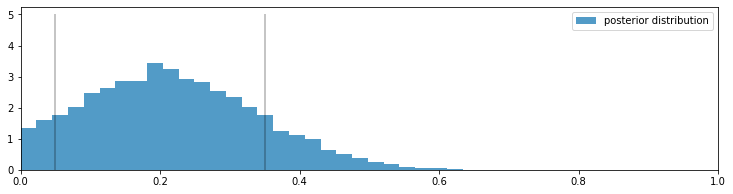

In [23]:
figsize(12.5, 3)
p_trace = burned_trace["freq_cheating"][15000:]
plt.hist(p_trace, histtype="stepfilled", density=True, alpha=0.85, bins=30, 
         label="posterior distribution", color="#348ABD")
plt.vlines([.05, .35], [0, 0], [5, 5], alpha=0.3)
plt.xlim(0, 1)
plt.legend();